In [ ]:
%pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
import pickle
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import time

from google.colab import drive
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler
from PIL import Image
from torchmetrics import Accuracy
from collections import Counter
import torch.nn.functional as F
from torchvision import models
from torch.utils.data.dataset import random_split

#**Data processing and Visualization**

In [ ]:
# Connects to drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
labels_path = '/content/MyDrive/MyDrive/ECSE551-MP1/Train_labels.xlsx'
train_path = '/content/MyDrive/MyDrive/ECSE551-MP1/Train.pkl'

classes = pd.read_excel(labels_path, index_col = 0)
with open(train_path, 'rb') as f:
    data = pickle.load(f)

In [ ]:
# Preprocess function for data augmentation
def preprocess(new_size, data):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((new_size, new_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])

    augmented_data = []
    for img in data:
        img = np.squeeze(img)  # Remove single channel dimension
        augmented_data.append(transform(img))

    return torch.stack(augmented_data)


new_size = 56

In [ ]:
classes.head()

,class
id,
1,8
2,7
3,0
4,1
5,4


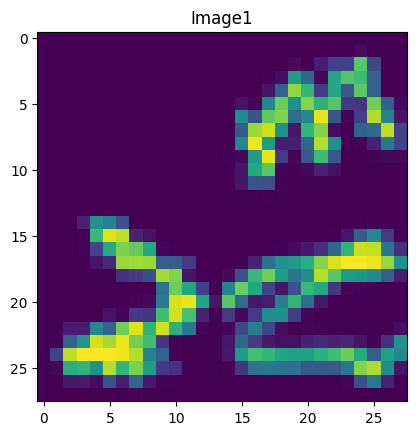

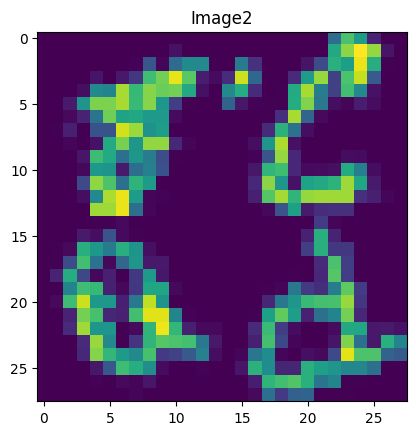

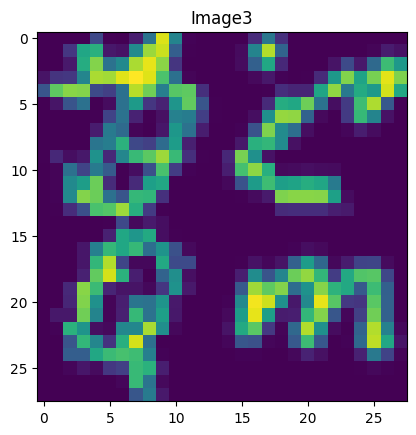

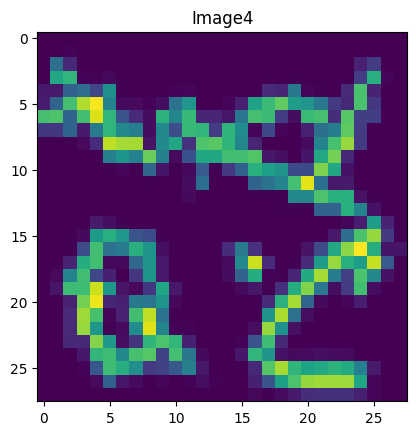

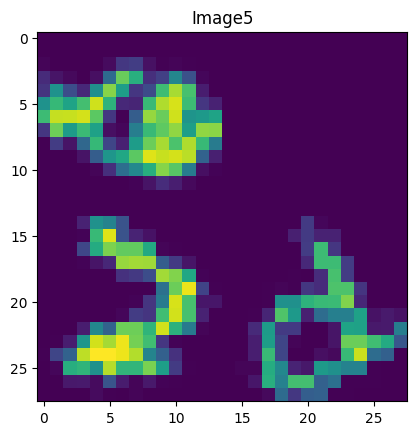

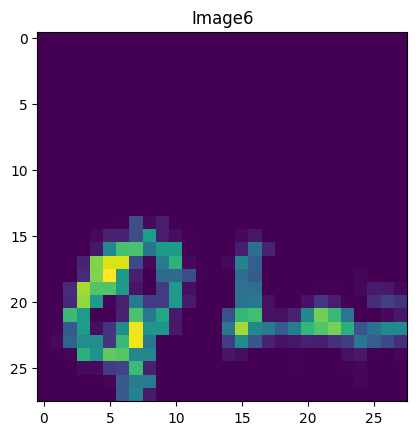

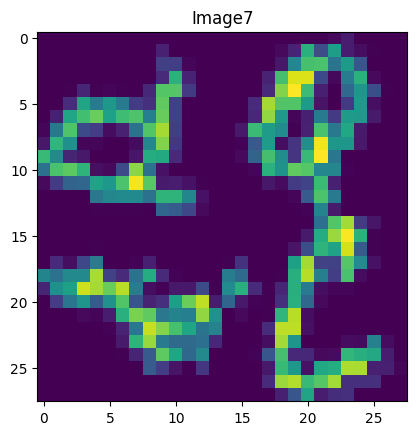

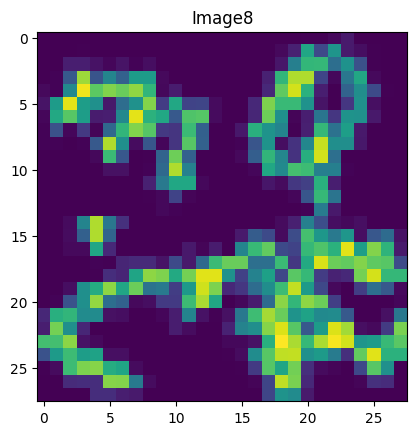

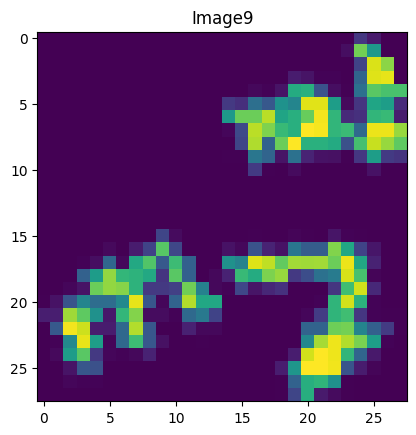

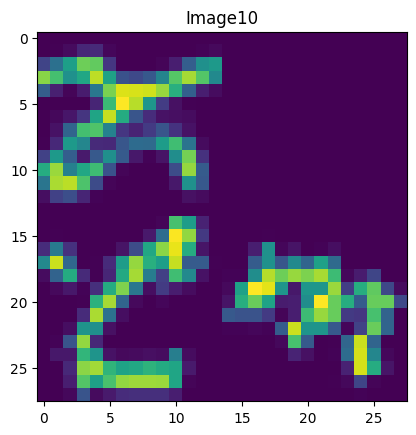

In [ ]:
# Preview of the 10 first images

for i in range(len(data) // 6000):
    image = data[i,:,:,:].T
    plt.imshow(image)
    plt.title(f'Image{i + 1}')
    plt.show()

In [ ]:
# Xavier/Glorot Initialization
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

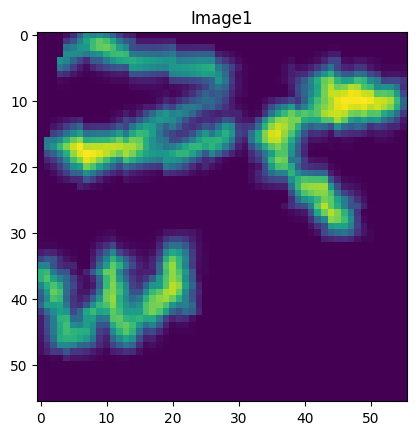

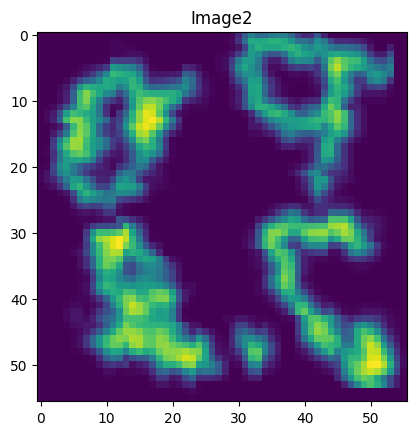

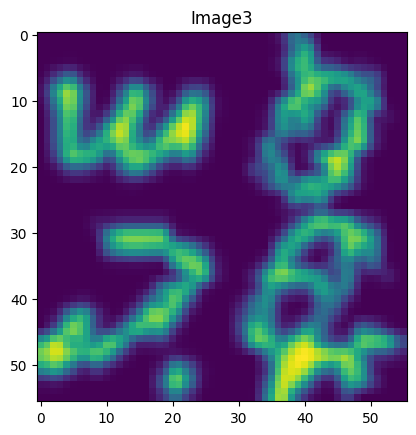

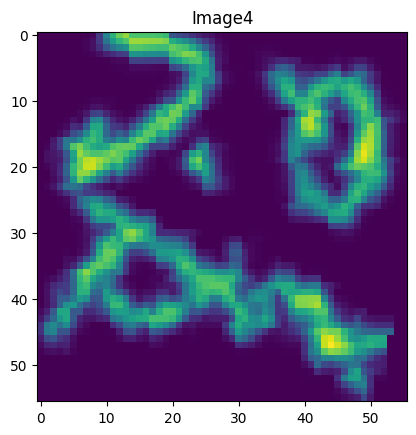

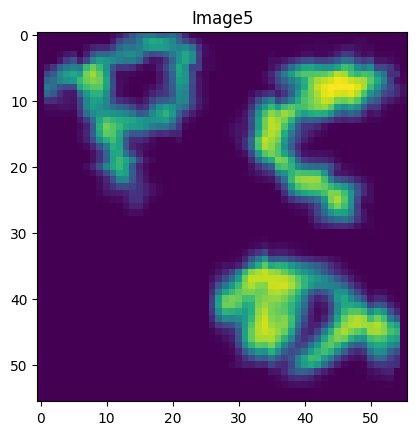

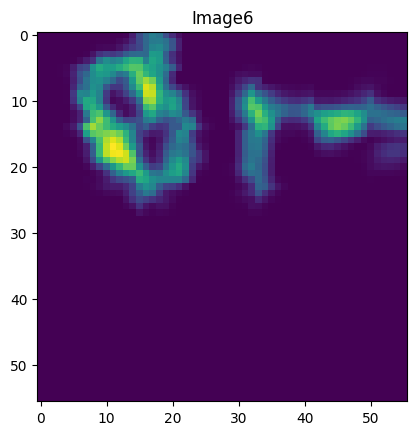

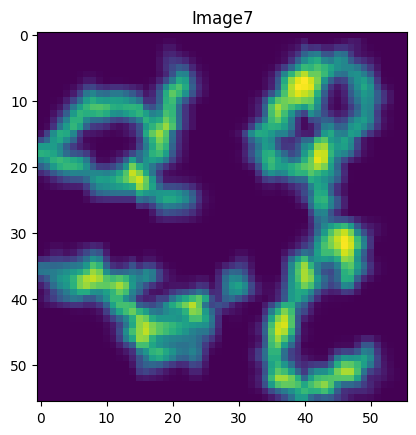

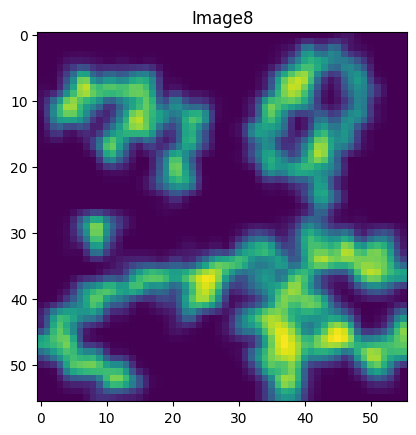

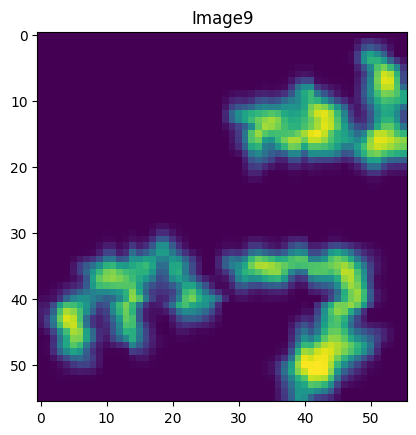

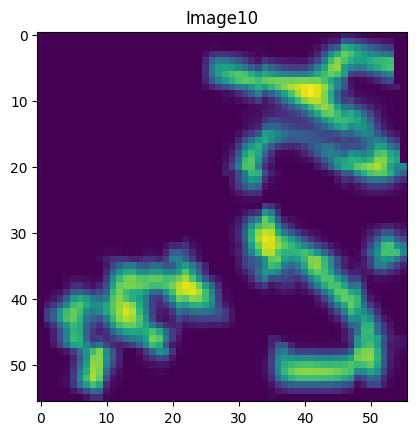

In [ ]:
new_images = inputs.numpy()

# Preview of the 10 first images

for i in range(len(new_images) // 6000):
    image = new_images[i,:,:,:].T
    plt.imshow(image)
    plt.title(f'Image{i + 1}')
    plt.show()

#**VGG16**

In [ ]:
#VGG 16 architecture


#Pretrained model VGG16:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class NetVGG(nn.Module):
    def __init__(self):
        super(NetVGG, self).__init__()

        vgg_firstlayer= models.vgg16(pretrained = False).features[0] #Making sure the pte-trained weights are dropped

        vgg=models.vgg16(pretrained = False).features[1:30]  #Making sure the pte-trained weights are dropped

        # Load VGG16 architecture

        w1=vgg_firstlayer.state_dict()['weight'][:,0,:,:]
        w2=vgg_firstlayer.state_dict()['weight'][:,1,:,:]
        w3=vgg_firstlayer.state_dict()['weight'][:,2,:,:]
        w4=w1+w2+w3 # add the three weigths of the channels
        w4=w4.unsqueeze(1)# make it 4 dimensional

        first_conv=nn.Conv2d(1, 64, 3, padding = (1,1)) #create a new conv layer
        first_conv.weigth=torch.nn.Parameter(w4, requires_grad=True) #initialize  the conv layer's weigths with w4
        first_conv.bias=torch.nn.Parameter(vgg_firstlayer.state_dict()['bias'], requires_grad=True) #initialize  the conv layer's weigths with vgg's first conv bias

        self.first_convlayer = first_conv
        self.vgg = nn.Sequential(vgg)


        self.fc1 = nn.Linear(512*7*7, 50)  # Adjust input size based on the output size of the last VGG16 layer

        # The last layer should have an output with the same dimension as the number of classes
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.first_convlayer(x)
        x = self.vgg(x)

        # Global average pooling
        x = F.adaptive_avg_pool2d(x, (7, 7))

        # Flatten for the custom linear layers
        x = x.view(x.size(0), -1)

        # Feedforward layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Apply log softmax to the output
        return F.log_softmax(x, dim=1)


network = NetVGG()

# #**VGG19**

In [ ]:
# We also added L-1 regularization to the previous model to reduce overfitting
# However, the models were too deep to not overfit, which lead these models to a weaker performance
# due to their high generalization error


class NetVGG19(nn.Module):
    def __init__(self):
        super(NetVGG19, self).__init__()

        vgg_firstlayer= models.vgg19(pretrained = False).features[0]

        vgg=models.vgg19(pretrained = False).features[1:30]

        # Load the pre-trained VGG19 model

        w1=vgg_firstlayer.state_dict()['weight'][:,0,:,:]
        w2=vgg_firstlayer.state_dict()['weight'][:,1,:,:]
        w3=vgg_firstlayer.state_dict()['weight'][:,2,:,:]
        w4=w1+w2+w3 # add the three weigths of the channels
        w4=w4.unsqueeze(1)# make it 4 dimensional

        first_conv=nn.Conv2d(1, 64, 3, padding = (1,1)) #create a new conv layer
        first_conv.weigth=torch.nn.Parameter(w4, requires_grad=True) #initialize  the conv layer's weigths with w4
        first_conv.bias=torch.nn.Parameter(vgg_firstlayer.state_dict()['bias'], requires_grad=True) #initialize  the conv layer's weigths with vgg's first conv bias

        self.first_convlayer = first_conv
        self.vgg = nn.Sequential(vgg)


        # Replace the last fully connected layer of VGG19 with a custom linear layer
        self.fc1 = nn.Linear(512*7*7, 50)  # Adjust input size based on the output size of the last VGG19 layer

        # The last layer should have an output with the same dimension as the number of classes
        self.fc2 = nn.Linear(50, 10)

        self.l1_lambda = 0.001

    def forward(self, x):
        x = self.first_convlayer(x)
        x = self.vgg(x)

        x = F.adaptive_avg_pool2d(x, (7, 7))

        # Flatten for the custom linear layers
        x = x.view(x.size(0), -1)

        # Feedforward layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Apply log softmax to the output
        return F.log_softmax(x, dim=1)

    def regularization_loss(self):
        l1_loss = 0.0
        for param in self.parameters():
            l1_loss += torch.norm(param, 1)
        return self.l1_lambda * l1_loss

    def total_loss(self, x, y):
        output = self.forward(x)
        loss = F.nll_loss(output, y)
        reg_loss = self.regularization_loss()
        return loss + reg_loss


network19 = NetVGG19()


In [ ]:
#Grid search for learning parameters and training loop for VGG-19


from torch.utils.data.dataset import random_split



step_size = 5
gamma = 0.1
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr = 0.01, momentum = 0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)
epochs = [15, 25, 35, 45]

inputs, labels = preprocess(new_size, data), torch.tensor(classes['class'].values)
dataset = TensorDataset(inputs, labels)
batchs = [60, 50, 40, 30, 70]




for e in epochs:
  for b in batchs:
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    epochs = e
    batch_size = b

    val_size = int(0.2 * len(dataset))  # We can adjust the validation set size as needed

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])

    # Create DataLoader instances for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network.to(device)




    for epoch in range(epochs):
        # Training
        network.train()
        total_correct_train = 0
        total_samples_train = 0
        total_loss_train = 0

        for input, label in train_loader:
            input, label = input.to(device), label.to(device)
            outputs = network(input)
            loss = error(outputs, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()

            _, predicted_train = outputs.max(1)
            total_samples_train += label.size(0)
            total_correct_train += (predicted_train == label).sum().item()

        average_loss_train = total_loss_train / len(train_loader)
        accuracy_train = total_correct_train / total_samples_train
        train_loss_history.append(average_loss_train)
        train_accuracy_history.append(accuracy_train)

        # Validation
        network.eval()
        total_correct_val = 0
        total_samples_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for input_val, label_val in val_loader:
                input_val, label_val = input_val.to(device), label_val.to(device)
                outputs_val = network(input_val)
                loss_val = error(outputs_val, label_val)

                total_loss_val += loss_val.item()

                _, predicted_val = outputs_val.max(1)
                total_samples_val += label_val.size(0)
                total_correct_val += (predicted_val == label_val).sum().item()

        average_loss_val = total_loss_val / len(val_loader)
        accuracy_val = total_correct_val / total_samples_val
        val_loss_history.append(average_loss_val)
        val_accuracy_history.append(accuracy_val)

        print(f'For a selection of epoch = {e}, and batch = {b}'
            f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {average_loss_train:.4f}, Training Accuracy: {accuracy_train:.4f}, '
              f'Validation Loss: {average_loss_val:.4f}, Validation Accuracy: {accuracy_val:.4f}')


NameError: ignored

In [ ]:
#Final training parameters found from the gridsearch above for the
#NetVGG19 training loop

from torch.utils.data.dataset import random_split


step_size = 5
gamma = 0.1
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network19.parameters(), lr = 0.01, momentum = 0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)
epochs = 20

inputs, labels = preprocess(new_size, data), torch.tensor(classes['class'].values)
dataset = TensorDataset(inputs, labels)
batch_size = 32





train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []


val_size = int(0.2 * len(dataset))  # We can adjust the validation set size as needed

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])

# Create DataLoader instances for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network19.to(device)




for epoch in range(epochs):
        # Training
        network19.train()
        total_correct_train = 0
        total_samples_train = 0
        total_loss_train = 0

        for input, label in train_loader:
            input, label = input.to(device), label.to(device)
            outputs = network19(input)
            loss = error(outputs, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()

            _, predicted_train = outputs.max(1)
            total_samples_train += label.size(0)
            total_correct_train += (predicted_train == label).sum().item()

        average_loss_train = total_loss_train / len(train_loader)
        accuracy_train = total_correct_train / total_samples_train
        train_loss_history.append(average_loss_train)
        train_accuracy_history.append(accuracy_train)

        # Validation
        network19.eval()
        total_correct_val = 0
        total_samples_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for input_val, label_val in val_loader:
                input_val, label_val = input_val.to(device), label_val.to(device)
                outputs_val = network19(input_val)
                loss_val = error(outputs_val, label_val)

                total_loss_val += loss_val.item()

                _, predicted_val = outputs_val.max(1)
                total_samples_val += label_val.size(0)
                total_correct_val += (predicted_val == label_val).sum().item()

        average_loss_val = total_loss_val / len(val_loader)
        accuracy_val = total_correct_val / total_samples_val
        val_loss_history.append(average_loss_val)
        val_accuracy_history.append(accuracy_val)


        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {average_loss_train:.4f}, Training Accuracy: {accuracy_train:.4f}, '
              f'Validation Loss: {average_loss_val:.4f}, Validation Accuracy: {accuracy_val:.4f}')


Epoch [1/20], Training Loss: 1.8381, Training Accuracy: 0.2963, Validation Loss: 1.7408, Validation Accuracy: 0.3564
Epoch [2/20], Training Loss: 1.4019, Training Accuracy: 0.4986, Validation Loss: 1.1667, Validation Accuracy: 0.5871
Epoch [3/20], Training Loss: 0.9866, Training Accuracy: 0.6716, Validation Loss: 0.8438, Validation Accuracy: 0.7302
Epoch [4/20], Training Loss: 0.7078, Training Accuracy: 0.7778, Validation Loss: 0.7053, Validation Accuracy: 0.7863
Epoch [5/20], Training Loss: 0.5168, Training Accuracy: 0.8386, Validation Loss: 0.5836, Validation Accuracy: 0.8207
Epoch [6/20], Training Loss: 0.3927, Training Accuracy: 0.8816, Validation Loss: 0.5668, Validation Accuracy: 0.8394
Epoch [7/20], Training Loss: 0.3138, Training Accuracy: 0.9037, Validation Loss: 0.4908, Validation Accuracy: 0.8600
Epoch [8/20], Training Loss: 0.2436, Training Accuracy: 0.9260, Validation Loss: 0.6271, Validation Accuracy: 0.8407
Epoch [9/20], Training Loss: 0.2091, Training Accuracy: 0.9367, 

In [ ]:
#We have implemented nested K fold cross validation.
#However, due to restricted computational ressources, we were not able to fully test it as it was taking too much time to run,
# even using colab's GPU

import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold

#Using K fold cross validation :
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

k_folds = 10
num_epochs = 15
loss_function = nn.CrossEntropyLoss()
results = {}
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []


val_size = int(0.2 * len(dataset))  # We can adjust the validation set size as needed

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = TensorDataset(inputs, labels)

# Start print
print('--------------------------------')

  # K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


    # Init the neural network
    network = NetVGG19()
    network.apply(reset_weights)

    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):

        # Get inputs
        inputs, targets = data

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
      print(f'Fold {key}: {value} %')
      sum += value
    print(f'Average: {sum/len(results.items())} %')

--------------------------------
FOLD 0
--------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(512,

#**VGG-5**

In [ ]:
#Helper methods to process the data
#Iteratively, we have found that the best way to process the data was to simply use the data as found in the dataset
# only transforming the image to PIL format

labels_path = '/content/MyDrive/MyDrive/ECSE551-MP1/Train_labels.xlsx'
train_path = '/content/MyDrive/MyDrive/ECSE551-MP1/Train.pkl'

classes = pd.read_excel(labels_path, index_col = 0)
with open(train_path, 'rb') as f:
    data = pickle.load(f)

# Preprocess function for data augmentation
def preprocess(new_size, data):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])

    augmented_data = []
    for img in data:
        img = np.squeeze(img)  # Remove single channel dimension
        augmented_data.append(transform(img))

    return torch.stack(augmented_data)






In [ ]:
#Custom VGG architecture implementation


import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoConvPool(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels2):
        super(TwoConvPool, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels1)
        self.conv2 = nn.Conv2d(out_channels1, out_channels2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x

class ThreeConvPool(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels2, out_channels3):
        super(ThreeConvPool, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels1)
        self.conv2 = nn.Conv2d(out_channels1, out_channels2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels2)
        self.conv3 = nn.Conv2d(out_channels2, out_channels3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        return x

class VGGNet5(nn.Module):
    def __init__(self):
        super(VGGNet5, self).__init__()
        self.block1 = TwoConvPool(1, 32, 32)
        self.block2 = TwoConvPool(32, 64, 64)
        self.block3 = ThreeConvPool(64, 128, 128, 128)
        self.block4 = ThreeConvPool(128, 256, 256, 256)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 4096)  # Adjust the input size here
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x




In [ ]:
#NetVGG5 loop

from torch.utils.data.dataset import random_split

network5 = VGGNet5()
step_size = 5
gamma = 0.05
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network5.parameters(), lr = 0.001, momentum = 0.96)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)
epochs = 35
inputs, labels = preprocess(new_size, data), torch.tensor(classes['class'].values)
dataset = TensorDataset(inputs, labels)
batch_size = 128





NameError: ignored

In [ ]:
#Custom VGG training loop

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

val_size = int(0.2 * len(dataset))  # We can adjust the validation set size as needed

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])

# Create DataLoader instances for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network5.to(device)




for epoch in range(epochs):
        # Training
        network5.train()
        total_correct_train = 0
        total_samples_train = 0
        total_loss_train = 0

        for input, label in train_loader:
            input, label = input.to(device), label.to(device)
            outputs = network5(input)
            loss = error(outputs, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()

            _, predicted_train = outputs.max(1)
            total_samples_train += label.size(0)
            total_correct_train += (predicted_train == label).sum().item()

        average_loss_train = total_loss_train / len(train_loader)
        accuracy_train = total_correct_train / total_samples_train
        train_loss_history.append(average_loss_train)
        train_accuracy_history.append(accuracy_train)

        # Validation
        network5.eval()
        total_correct_val = 0
        total_samples_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for input_val, label_val in val_loader:
                input_val, label_val = input_val.to(device), label_val.to(device)
                outputs_val = network5(input_val)
                loss_val = error(outputs_val, label_val)

                total_loss_val += loss_val.item()

                _, predicted_val = outputs_val.max(1)
                total_samples_val += label_val.size(0)
                total_correct_val += (predicted_val == label_val).sum().item()

        average_loss_val = total_loss_val / len(val_loader)
        accuracy_val = total_correct_val / total_samples_val
        val_loss_history.append(average_loss_val)
        val_accuracy_history.append(accuracy_val)


        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {average_loss_train:.4f}, Training Accuracy: {accuracy_train:.4f}, '
              f'Validation Loss: {average_loss_val:.4f}, Validation Accuracy: {accuracy_val:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/35], Training Loss: 2.3012, Training Accuracy: 0.1092, Validation Loss: 2.2976, Validation Accuracy: 0.1419
Epoch [2/35], Training Loss: 2.2521, Training Accuracy: 0.1890, Validation Loss: 2.1456, Validation Accuracy: 0.3080
Epoch [3/35], Training Loss: 2.0294, Training Accuracy: 0.4424, Validation Loss: 1.9393, Validation Accuracy: 0.5334
Epoch [4/35], Training Loss: 1.8557, Training Accuracy: 0.6165, Validation Loss: 1.8443, Validation Accuracy: 0.6219
Epoch [5/35], Training Loss: 1.7651, Training Accuracy: 0.7032, Validation Loss: 1.8012, Validation Accuracy: 0.6621
Epoch [6/35], Training Loss: 1.7189, Training Accuracy: 0.7455, Validation Loss: 1.7362, Validation Accuracy: 0.7280
Epoch [7/35], Training Loss: 1.6916, Training Accuracy: 0.7720, Validation Loss: 1.7229, Validation Accuracy: 0.7378
Epoch [8/35], Training Loss: 1.6770, Training Accuracy: 0.7850, Validation Loss: 1.7045, Validation Accuracy: 0.7580
Epoch [9/35], Training Loss: 1.6624, Training Accuracy: 0.8003, 

In [ ]:
test_path = '/content/MyDrive/MyDrive/ECSE551-MP1/Test.pkl'
with open(test_path, 'rb') as f:
    X_test = pickle.load(f)

X_test_tensor = preprocess(new_size, X_test)

training_history_VGG5_1 = {'loss': train_loss_history, 'accuracy': train_accuracy_history}
torch.save(training_history_VGG5_1, 'training_historyVGG5_1.pth')
torch.save(network5.state_dict(), 'raining_historyVGG5_1.pth')
torch.cuda.empty_cache()
chunk_size = 1000  #Can be further adjusted depending on size of testing set.
predictions_list = []
network5.eval()

with torch.no_grad():
    for i in range(0, len(X_test_tensor), chunk_size):
        X_chunk = X_test_tensor[i:i+chunk_size]
        X_chunk = X_chunk.to(device)
        y = network5(X_chunk)
        probs = torch.nn.functional.softmax(y, dim=1)
        _, predictions = torch.max(probs, 1)
        predictions_list.append(predictions.cpu().numpy())

predictions = np.concatenate(predictions_list)
submission = pd.DataFrame({'class' : predictions})
submission.index = [i for i in range(len(predictions))]
submission.index.name = 'id'
submission
submission.to_csv('predictionsVGG5_1_2.csv')

#**Sample VGG-5 and Spinal VGG-5**

In [ ]:
#Generic Architecture for VGG-5 and Spinal VGG Architecture


import torch
import torchvision
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np

num_classes = 10

class VGG_5_2(nn.Module):

    def two_conv_pool(self, in_channels, f1, f2):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s

    def three_conv_pool(self,in_channels, f1, f2, f3):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.Conv2d(f2, f3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s


    def __init__(self, num_classes=62):
        super(VGG_5_2, self).__init__()
        self.l1 = self.two_conv_pool(1, 64, 64)
        self.l2 = self.two_conv_pool(64, 128, 128)
        self.l3 = self.three_conv_pool(128, 256, 256, 256)
        self.l4 = self.three_conv_pool(256, 256, 256, 256)

        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


Half_width =128
layer_width =128

class SpinalVGG(nn.Module):

    def two_conv_pool(self, in_channels, f1, f2):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s

    def three_conv_pool(self,in_channels, f1, f2, f3):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.Conv2d(f2, f3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s


    def __init__(self, num_classes=62):
        super(SpinalVGG, self).__init__()
        self.l1 = self.two_conv_pool(1, 64, 64)
        self.l2 = self.two_conv_pool(64, 128, 128)
        self.l3 = self.three_conv_pool(128, 256, 256, 256)
        self.l4 = self.three_conv_pool(256, 256, 256, 256)


        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(Half_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(Half_width+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, num_classes),)


    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = x.view(x.size(0), -1)

        x1 = self.fc_spinal_layer1(x[:, 0:Half_width])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,Half_width:2*Half_width], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:Half_width], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,Half_width:2*Half_width], x3], dim=1))

        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        x = self.fc_out(x)

        return F.log_softmax(x, dim=1)



In [ ]:
#SpinalVGG training parameters

from torch.utils.data.dataset import random_split
new_size = 28
networkSpinal = SpinalVGG()
step_size = 5
gamma = 0.01
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(networkSpinal.parameters(), lr = 0.001, momentum = 0.96)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)
epochs = 25
inputs, labels = preprocess(new_size, data), torch.tensor(classes['class'].values)
dataset = TensorDataset(inputs, labels)
batch_size = 30






In [ ]:
#SPINALVGG-TRAINING LOOP:


train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

val_size = int(0.2 * len(dataset))  # We can adjust the validation set size as needed

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])

# Create DataLoader instances for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
networkSpinal.to(device)




for epoch in range(epochs):
        # Training
        networkSpinal.train()
        total_correct_train = 0
        total_samples_train = 0
        total_loss_train = 0

        for input, label in train_loader:
            input, label = input.to(device), label.to(device)
            outputs = networkSpinal(input)
            loss = error(outputs, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()

            _, predicted_train = outputs.max(1)
            total_samples_train += label.size(0)
            total_correct_train += (predicted_train == label).sum().item()

        average_loss_train = total_loss_train / len(train_loader)
        accuracy_train = total_correct_train / total_samples_train
        train_loss_history.append(average_loss_train)
        train_accuracy_history.append(accuracy_train)

        # Validation
        networkSpinal.eval()
        total_correct_val = 0
        total_samples_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for input_val, label_val in val_loader:
                input_val, label_val = input_val.to(device), label_val.to(device)
                outputs_val = networkSpinal(input_val)
                loss_val = error(outputs_val, label_val)

                total_loss_val += loss_val.item()

                _, predicted_val = outputs_val.max(1)
                total_samples_val += label_val.size(0)
                total_correct_val += (predicted_val == label_val).sum().item()

        average_loss_val = total_loss_val / len(val_loader)
        accuracy_val = total_correct_val / total_samples_val
        val_loss_history.append(average_loss_val)
        val_accuracy_history.append(accuracy_val)


        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {average_loss_train:.4f}, Training Accuracy: {accuracy_train:.4f}, '
              f'Validation Loss: {average_loss_val:.4f}, Validation Accuracy: {accuracy_val:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/25], Training Loss: 1.7681, Training Accuracy: 0.3690, Validation Loss: 0.9321, Validation Accuracy: 0.6890
Epoch [2/25], Training Loss: 0.7516, Training Accuracy: 0.7557, Validation Loss: 0.4703, Validation Accuracy: 0.8524
Epoch [3/25], Training Loss: 0.4323, Training Accuracy: 0.8667, Validation Loss: 0.3250, Validation Accuracy: 0.8969
Epoch [4/25], Training Loss: 0.3005, Training Accuracy: 0.9087, Validation Loss: 0.2680, Validation Accuracy: 0.9163
Epoch [5/25], Training Loss: 0.2218, Training Accuracy: 0.9322, Validation Loss: 0.2709, Validation Accuracy: 0.9150
Epoch [6/25], Training Loss: 0.1718, Training Accuracy: 0.9469, Validation Loss: 0.2405, Validation Accuracy: 0.9274
Epoch [7/25], Training Loss: 0.1329, Training Accuracy: 0.9580, Validation Loss: 0.2756, Validation Accuracy: 0.9214
Epoch [8/25], Training Loss: 0.1052, Training Accuracy: 0.9676, Validation Loss: 0.2231, Validation Accuracy: 0.9347
Epoch [9/25], Training Loss: 0.0883, Training Accuracy: 0.9732, 

In [ ]:
#Testing Loop SpinalVGG

test_path = '/content/MyDrive/MyDrive/ECSE551-MP1/Test.pkl'
with open(test_path, 'rb') as f:
    X_test = pickle.load(f)

X_test_tensor = preprocess(new_size, X_test)

training_history_VGGSpinal = {'loss': train_loss_history, 'accuracy': train_accuracy_history}
torch.save(training_history_VGGSpinal, 'training_historyVGGSpinal.pth')
torch.save(networkSpinal.state_dict(), 'raining_historyVGGSpinal.pth')
torch.cuda.empty_cache()
chunk_size = 1000  # We can adjust the size of the chunck to evaluate here
predictions_list = []
networkSpinal.eval()

with torch.no_grad():
    for i in range(0, len(X_test_tensor), chunk_size):
        X_chunk = X_test_tensor[i:i+chunk_size]
        X_chunk = X_chunk.to(device)
        y = networkSpinal(X_chunk)
        probs = torch.nn.functional.softmax(y, dim=1)
        _, predictions = torch.max(probs, 1)
        predictions_list.append(predictions.cpu().numpy())

predictions = np.concatenate(predictions_list)
submission = pd.DataFrame({'class' : predictions})
submission.index = [i for i in range(len(predictions))]
submission.index.name = 'id'
submission
submission.to_csv('predictionsVGGSpinal4.csv')

In [ ]:
#settings for VGG_5 Training Loop

from torch.utils.data.dataset import random_split
new_size = 28
networkSpinal = VGG_5_2()
step_size = 5
gamma = 0.0001
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(networkSpinal.parameters(), lr = 0.001, momentum = 0.96)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)
epochs = 200
inputs, labels = preprocess(new_size, data), torch.tensor(classes['class'].values)
dataset = TensorDataset(inputs, labels)
batch_size = 32


In [ ]:
#VGG_5 TRAINING LOOP:


train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []


val_size = int(0.2 * len(dataset))  # We can adjust the validation set size as needed

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_size, val_size])

# Create DataLoader instances for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
networkSpinal.to(device)




for epoch in range(epochs):
        # Training
        networkSpinal.train()
        total_correct_train = 0
        total_samples_train = 0
        total_loss_train = 0

        for input, label in train_loader:
            input, label = input.to(device), label.to(device)
            outputs = networkSpinal(input)
            loss = error(outputs, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()

            _, predicted_train = outputs.max(1)
            total_samples_train += label.size(0)
            total_correct_train += (predicted_train == label).sum().item()

        average_loss_train = total_loss_train / len(train_loader)
        accuracy_train = total_correct_train / total_samples_train
        train_loss_history.append(average_loss_train)
        train_accuracy_history.append(accuracy_train)

        # Validation
        networkSpinal.eval()
        total_correct_val = 0
        total_samples_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for input_val, label_val in val_loader:
                input_val, label_val = input_val.to(device), label_val.to(device)
                outputs_val = networkSpinal(input_val)
                loss_val = error(outputs_val, label_val)

                total_loss_val += loss_val.item()

                _, predicted_val = outputs_val.max(1)
                total_samples_val += label_val.size(0)
                total_correct_val += (predicted_val == label_val).sum().item()

        average_loss_val = total_loss_val / len(val_loader)
        accuracy_val = total_correct_val / total_samples_val
        val_loss_history.append(average_loss_val)
        val_accuracy_history.append(accuracy_val)


        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {average_loss_train:.4f}, Training Accuracy: {accuracy_train:.4f}, '
              f'Validation Loss: {average_loss_val:.4f}, Validation Accuracy: {accuracy_val:.4f}')


Epoch [1/200], Training Loss: 1.7878, Training Accuracy: 0.3552, Validation Loss: 1.1214, Validation Accuracy: 0.6278
Epoch [2/200], Training Loss: 0.7614, Training Accuracy: 0.7545, Validation Loss: 0.5230, Validation Accuracy: 0.8381
Epoch [3/200], Training Loss: 0.4514, Training Accuracy: 0.8590, Validation Loss: 0.3758, Validation Accuracy: 0.8804
Epoch [4/200], Training Loss: 0.3084, Training Accuracy: 0.9062, Validation Loss: 0.3252, Validation Accuracy: 0.9008
Epoch [5/200], Training Loss: 0.2285, Training Accuracy: 0.9304, Validation Loss: 0.3255, Validation Accuracy: 0.9028
Epoch [6/200], Training Loss: 0.1793, Training Accuracy: 0.9453, Validation Loss: 0.2804, Validation Accuracy: 0.9193
Epoch [7/200], Training Loss: 0.1377, Training Accuracy: 0.9579, Validation Loss: 0.2522, Validation Accuracy: 0.9316
Epoch [8/200], Training Loss: 0.1081, Training Accuracy: 0.9672, Validation Loss: 0.2399, Validation Accuracy: 0.9320
Epoch [9/200], Training Loss: 0.0903, Training Accuracy:

In [ ]:
#Testing Loop VGG_5

test_path = '/content/MyDrive/MyDrive/ECSE551-MP1/Test.pkl'
with open(test_path, 'rb') as f:
    X_test = pickle.load(f)

X_test_tensor = preprocess(new_size, X_test)

training_history_VGGSpinal = {'loss': train_loss_history, 'accuracy': train_accuracy_history}
torch.save(training_history_VGGSpinal, 'training_historyVGGSpinal.pth')
torch.save(networkSpinal.state_dict(), 'raining_historyVGGSpinal.pth')
torch.cuda.empty_cache()
chunk_size = 1000  # Can be adjusted as needed
predictions_list = []
networkSpinal.eval()

with torch.no_grad():
    for i in range(0, len(X_test_tensor), chunk_size):
        X_chunk = X_test_tensor[i:i+chunk_size]
        X_chunk = X_chunk.to(device)
        y = networkSpinal(X_chunk)
        probs = torch.nn.functional.softmax(y, dim=1)
        _, predictions = torch.max(probs, 1)
        predictions_list.append(predictions.cpu().numpy())

predictions = np.concatenate(predictions_list)
submission = pd.DataFrame({'class' : predictions})
submission.index = [i for i in range(len(predictions))]
submission.index.name = 'id'
submission
submission.to_csv('predictionsVGG_5_4.csv')